In [431]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

df = pd.read_csv("/Users/suyashgoel/product-recommendation/shopping_behavior_updated.csv")

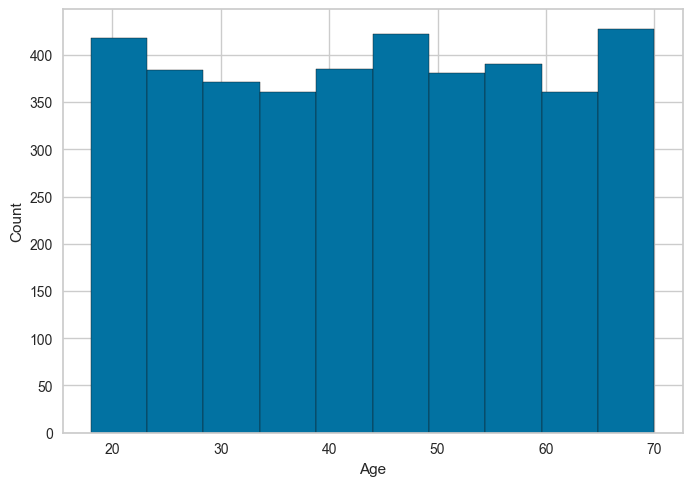

In [432]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df['Age'], bins= 10, edgecolor= 'k', alpha = 1.0)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [433]:
updated_df = df[['Age','Gender', 'Location', 'Season', 'Subscription Status', 'Previous Purchases', 'Frequency of Purchases']]

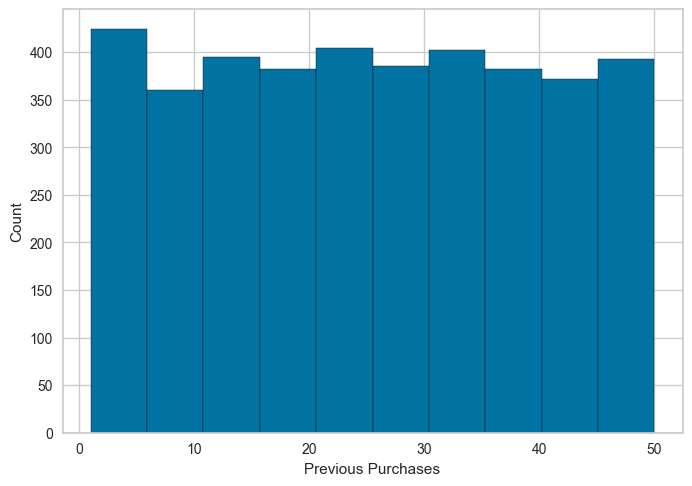

In [434]:
plt.hist(df['Previous Purchases'], bins= 10, edgecolor= 'k', alpha = 1.0)
plt.xlabel('Previous Purchases')
plt.ylabel('Count')
plt.show()

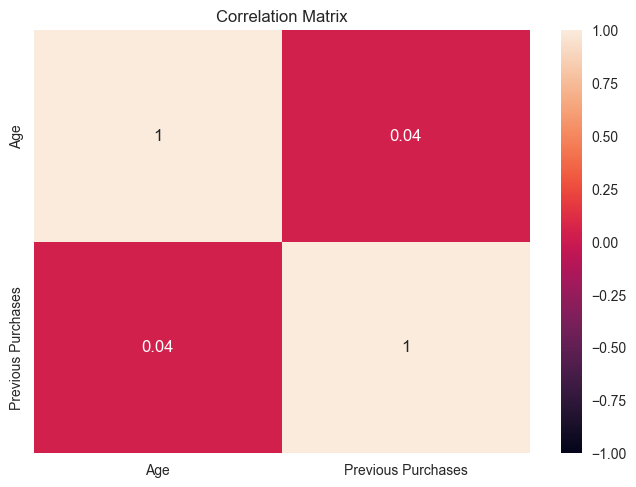

In [435]:
plt.figure()
sns.heatmap(updated_df.select_dtypes(include=['int', 'float']).corr(), vmin = -1, vmax = 1, annot= True)
plt.title('Correlation Matrix')
plt.show()

In [436]:
#cramers v for categorical variables
from scipy.stats import chisquare, chi2_contingency
import math
import numpy as np

def cramers(df):
    num_cols = df.shape[1]
    cramer_matrix = np.zeros((num_cols, num_cols))
    for cat1 in range(num_cols):
        for cat2 in range(num_cols):
            ct = pd.crosstab(df[df.columns[cat1]], df[df.columns[cat2]])
            c, p, dof, expected = chi2_contingency(ct) 
            n = sum(np.sum(ct))
            k = min(ct.shape)
            cramer_matrix[cat1, cat2] = math.sqrt(c / (n * k))
    cramer_matrix = pd.DataFrame(cramer_matrix, columns=df.columns, index=df.columns)
    return cramer_matrix

<Axes: >

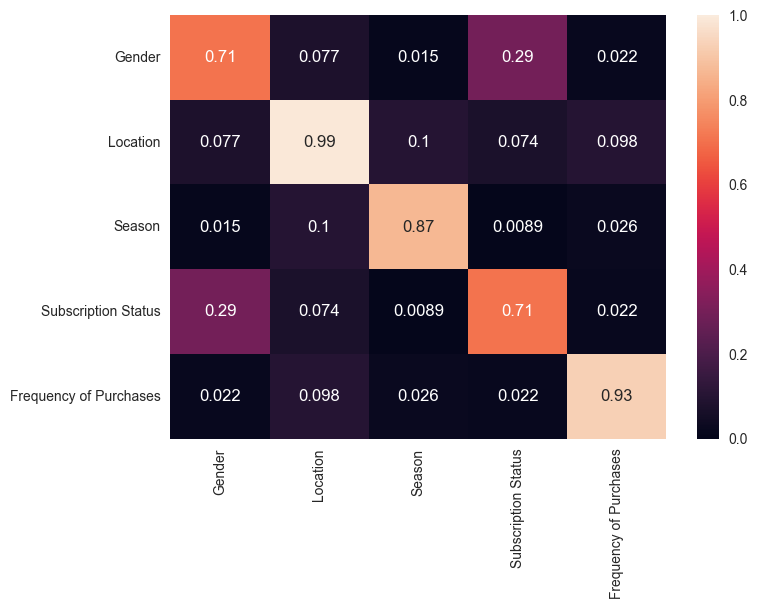

In [437]:
cat_var = updated_df.select_dtypes('object')

sns.heatmap(cramers(cat_var), vmin = 0, vmax = 1, annot= True)

In [438]:
from sklearn.preprocessing import StandardScaler


scaled_df = pd.concat([updated_df["Age"], updated_df["Previous Purchases"]], axis=1)

scaler = StandardScaler().fit_transform(scaled_df)

scaled_df = pd.DataFrame(scaler, columns= ["Age", "Previous Purchases"])

updated_df.drop(columns=['Age', 'Previous Purchases'], inplace=True)
updated_df = pd.concat([updated_df, scaled_df], axis=1)

/var/folders/5l/7bmxvb2x6sq3y8958yv03lq40000gn/T/ipykernel_3843/2516486037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_df.drop(columns=['Age', 'Previous Purchases'], inplace=True)


In [439]:
gender = pd.get_dummies(updated_df['Gender'], drop_first=True, dtype=int)
loc = pd.get_dummies(updated_df['Location'], drop_first=True, dtype=int)
season = pd.get_dummies(updated_df['Season'], drop_first=True, dtype=int)
status = pd.get_dummies(updated_df['Subscription Status'], drop_first=True, dtype=int)
freq = pd.get_dummies(updated_df['Frequency of Purchases'], drop_first=True, dtype=int)

updated_df = pd.concat([updated_df, gender, loc, season, status, freq], axis=1)
updated_df.drop(columns=['Gender', 'Location', 'Season', 'Subscription Status', 'Frequency of Purchases'], inplace=True)

In [440]:
updated_df.head

<bound method NDFrame.head of            Age  Previous Purchases  Male  Alaska  Arizona  Arkansas  \
0     0.718913           -0.785831     1       0        0         0   
1    -1.648629           -1.616552     1       0        0         0   
2     0.390088           -0.162789     1       0        0         0   
3    -1.517099            1.637107     1       0        0         0   
4     0.061263            0.391025     1       0        0         0   
...        ...                 ...   ...     ...      ...       ...   
3895 -0.267563            0.460252     0       0        0         0   
3896  0.521618            1.083293     0       0        0         0   
3897  0.127028           -0.093563     0       0        0         0   
3898 -0.004502           -0.093563     0       0        0         0   
3899  0.521618            0.529479     0       0        0         0   

      California  Colorado  Connecticut  Delaware  ...  Spring  Summer  \
0              0         0            0    

In [441]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(updated_df)

updated_df = pd.DataFrame(pca.transform(updated_df), columns=['PC1','PC2', 'PC3'])

updated_df

,PC1,PC2,PC3
0,0.041575,1.025800,0.731058
1,2.301602,-0.065500,0.761871
2,-0.185943,0.399477,0.744902
3,-0.120892,-2.220085,0.687756
4,-0.340618,-0.228713,0.710203
...,...,...,...
3895,-0.124497,-0.497089,-0.647198
3896,-1.111234,-0.368327,-0.738951
3897,-0.026501,0.182105,-0.687465
3898,0.076714,0.080459,-0.632561


In [442]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 39 , init = 'k-means++')

labels = kmeans.fit_predict(updated_df)
updated_df["Clusters"] = labels

In [443]:
print(updated_df.loc[updated_df["Clusters"] == 10])

           PC1       PC2       PC3  Clusters
1141  0.353746 -0.141949  0.051576        10
1151  0.194359 -0.058080  0.072319        10
1174  0.420044  0.188137  0.015472        10
1175  0.367422 -0.444591  0.055797        10
1178  0.434241 -0.197127  0.071682        10
...        ...       ...       ...       ...
2534  0.302345  0.022504  0.079625        10
2539  0.589760 -0.447492  0.046759        10
2541  1.122820  0.099860  0.086347        10
2561  0.703475 -0.390869  0.067996        10
2630  0.943737 -0.433826  0.069791        10

[108 rows x 4 columns]


In [444]:
df = pd.concat([df, updated_df["Clusters"]], axis=1)

In [445]:
c10 = df.loc[df['Clusters'] == 10]
c10

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Clusters
1141,1142,39,Male,Gloves,Accessories,33,Ohio,S,Silver,Winter,4.7,No,Next Day Air,Yes,Yes,23,PayPal,Fortnightly,10
1151,1152,41,Male,Blouse,Clothing,86,Ohio,M,Gray,Spring,4.2,No,Express,Yes,Yes,24,Credit Card,Weekly,10
1174,1175,42,Male,Backpack,Accessories,31,Michigan,M,Black,Winter,4.3,No,Express,Yes,Yes,19,Bank Transfer,Bi-Weekly,10
1175,1176,35,Male,Belt,Accessories,81,New Jersey,M,Beige,Spring,4.1,No,Store Pickup,Yes,Yes,26,PayPal,Quarterly,10
1178,1179,37,Male,Dress,Clothing,22,South Carolina,M,Teal,Spring,4.9,No,Express,Yes,Yes,23,Debit Card,Annually,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2535,41,Male,Sunglasses,Accessories,42,Virginia,XL,Red,Fall,3.2,No,Free Shipping,No,No,22,Cash,Weekly,10
2539,2540,33,Male,Sandals,Footwear,73,Massachusetts,M,Purple,Fall,4.1,No,Next Day Air,No,No,24,Cash,Bi-Weekly,10
2541,2542,33,Male,Scarf,Accessories,58,Washington,M,Silver,Spring,2.7,No,Next Day Air,No,No,13,Venmo,Every 3 Months,10
2561,2562,32,Male,Hoodie,Clothing,20,New York,L,Magenta,Spring,2.7,No,Free Shipping,No,No,22,Debit Card,Quarterly,10


In [446]:
c25 = df.loc[df['Clusters'] == 29]
c25

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Clusters
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,29
8,9,26,Male,Coat,Outerwear,97,West Virginia,L,Silver,Summer,2.6,Yes,Express,Yes,Yes,8,Venmo,Annually,29
11,12,30,Male,Shorts,Clothing,68,Hawaii,S,Olive,Winter,4.9,Yes,Store Pickup,Yes,Yes,10,Bank Transfer,Fortnightly,29
66,67,31,Male,Blouse,Clothing,94,Pennsylvania,S,Magenta,Winter,4.7,Yes,2-Day Shipping,Yes,Yes,3,Venmo,Every 3 Months,29
111,112,26,Male,Belt,Accessories,75,Massachusetts,L,Purple,Summer,5.0,Yes,Free Shipping,Yes,Yes,9,Credit Card,Annually,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,968,27,Male,Hoodie,Clothing,26,Georgia,S,Silver,Summer,3.7,Yes,Store Pickup,Yes,Yes,4,Cash,Weekly,29
984,985,26,Male,Shoes,Footwear,78,Utah,M,Green,Summer,3.4,Yes,Free Shipping,Yes,Yes,8,Credit Card,Bi-Weekly,29
985,986,32,Male,Handbag,Accessories,80,West Virginia,M,Gray,Fall,5.0,Yes,Express,Yes,Yes,12,Bank Transfer,Annually,29
1027,1028,33,Male,Jewelry,Accessories,90,Ohio,L,Teal,Summer,2.8,Yes,Next Day Air,Yes,Yes,11,Cash,Monthly,29
